[Open In Colab](https://colab.research.google.com/github/joelbenjohn/pyCUFSM/blob/master/Jupyter_Notebooks/pyCUFSM.ipynb)

# Clone Github
No need to run this cell for local host

In [ ]:
!rm -rf /content/pyCUFSM
!git clone https://github.com/ClearCals/pyCUFSM

import sys
sys.path.insert(1, '/content/pyCUFSM')

# Pre Processing

In [1]:
# This example presents a very simple Zed section,
# solved for pure bending about the X-axis,
# in the Metric unit system
import numpy as np
import matplotlib.pyplot as plt
from pycufsm.fsm import strip
from pycufsm.preprocess import stress_gen
from pycufsm.preprocess import yieldMP
from pycufsm.preprocess import doubler
import pycufsm.plotters as plotters
import cutwp_prop2

# Define an isotropic material
props = [[0, 29500, 29500, 0.3, 0.3, 29500 / (2 * (1 + 0.3))]]

# Nodal location units are inches
nodes = np.array([[0, 2.5, 0.773, 1, 1, 1, 1, 0], [1, 2.5, 0, 1, 1, 1, 1, 0],
             [2, 1.25, 0, 1, 1, 1, 1, 0], [3, 0, 0, 1, 1, 1, 1, 0],
             [4, 0, 3, 1, 1, 1, 1, 0], [5, 0, 6, 1, 1, 1, 1, 0],
             [6, 0, 9, 1, 1, 1, 1, 0], [7, 1.25, 9, 1, 1, 1, 1, 0],
             [8, 2.5, 9, 1, 1, 1, 1, 0], [9, 2.5, 8.227, 1, 1, 1, 1, 0]])

elements = np.array([[0, 0, 1, 0.059, 0], [1, 1, 2, 0.059, 0], [2, 2, 3, 0.059, 0],
                [3, 3, 4, 0.059, 0], [4, 4, 5, 0.059, 0], [5, 5, 6, 0.059, 0],
                [6, 6, 7, 0.059, 0], [7, 7, 8, 0.059, 0], [8, 8, 9, 0.059, 0]])
#PreProcess feature
#Doubler

nodes, elements = doubler(nodes, elements)

# These lengths will generally provide sufficient accuracy for local, distortional, and global buckling modes

# lengths = np.array([
#     10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160,
#     170, 180, 190, 200, 250, 300, 350, 400, 450, 500, 600, 700, 800, 900,
#     1000, 1100, 1200, 1300, 1400, 1500, 2000, 2500, 3000, 3500, 4000, 4500,
#     5000, 6000, 7000, 8000, 9000, 10000
# ])

###Start at a, End at b, n equal spaced intervals
#length=np.linspace(a,b,n)

###Start at 10^0, End at 10^4, with 100 log spaced intervals
lengths = np.logspace(0,4,100)

# No special springs or constraints
springs = []
constraints = []

# Values here correspond to signature curve basis and orthogonal based upon geometry
gbt_con = {
    'glob': [0],
    'dist': [0],
    'local': [0],
    'other': [0],
    'o_space': 1,
    'couple': 1,
    'orth': 2,
    'norm': 0,
}
# Simply-supported boundary conditions
b_c = 'S-S'

# For signature curve analysis, only a single array of ones makes sense here
m_all = np.ones((len(lengths), 1))

# Solve for 10 eigenvalues
n_eigs = 10

# Calculate Section Properties
sect_props = cutwp_prop2.cutwp_prop2(nodes[:, 1:3], elements[:, 1:4])

# Yield Strength
fy = 50
unsymmetric = 1 #i.e. do a restrained bending calculation
# Generate the stress points assuming 500 MPa yield and X-axis bending
Fyield = yieldMP(nodes, fy, sect_props, unsymmetric)
nodes_p = stress_gen(nodes=nodes,
                     forces={
                         'P': Fyield['P']*0,
                         'Mxx': Fyield['Mxx']*1,
                         'Myy': Fyield['Myy']*0,
                         'M11': Fyield['M11']*0,
                         'M22': Fyield['M22']*0
                     },
                     sect_props=sect_props,
                     unsymm = unsymmetric,
                    fy =fy
                    )

#####CALL CROSS SECTION
#Flag = {node, elem, mat, stress, stresspic, coord, constraints, springs, origin, propaxis}
flag = np.array([1, 0, 0, 0, 1, 0, 0, 0, 0, 0])
plotters.crossect(nodes_p, elements, springs, constraints,flag)
plt.show()

ModuleNotFoundError: No module named 'pycufsm'

# Analysis

In [8]:
# Perform the Finite Strip Method analysis
signature, curve, shapes = strip(props=props,
                                 nodes=nodes_p,
                                 elements=elements,
                                 lengths=lengths,
                                 springs=springs,
                                 constraints=constraints,
                                 gbt_con=gbt_con,
                                 b_c=b_c,
                                 m_all=m_all,
                                 n_eigs=n_eigs,
                                 sect_props=sect_props)
signature = np.array(signature)
curves = np.array(curve)
shapes = np.array(shapes)

# Post Processing

## Displaced Shape

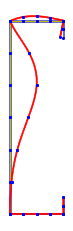

In [9]:
######POST PROCESSING#########
#Choose mode number
modeindex = 1
length_index = 20
fileddisplay = [1]
######DISPLACED SHAPE####
undef = 1
scalem = 5
m_a = [1]
SurfPos = 1/2
mode = shapes[length_index-1, :, modeindex-1]
####CALL DISPLACED SHAPE
x = dispshap.dispshap(undef, node, element, mode, scalem, springs, m_a, b_c ,SurfPos)

## Signature Curve

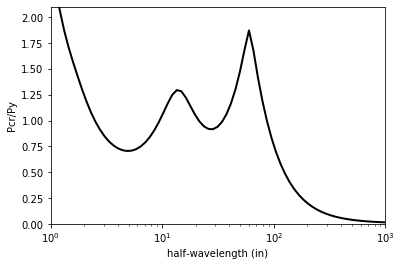

In [10]:
####SIGNATURE CURVE####
###Buckling halfwavelenth plot from a signature analysis
plt.semilogx(lengths, signature, 'k', linewidth= 2)
plt.xlim((1, 1000))
maximum = np.max(signature)
median = np.median(signature)
ubound = np.min([maximum, 3*median])
plt.ylim((0, ubound))
plt.xlabel('half-wavelength (in)')
plt.ylabel('Pcr/Py')
plt.show()
clas = 0
minopt = 1
logopt = 1
clasopt = 0
xmin = np.min(lengths)*10/11
xmax = np.max(lengths)*11/10
ymin = 0
curve_sign = np.zeros((len(lengths),2))
curve = np.zeros(((len(lengths),n_eigs,2)))
for j in range(len(lengths)):
    for i in range(n_eigs):
        curve[j, i, 0] = lengths[j]
        curve[j, i, 1] = curves[j, i]
for j in range(len(lengths)):
    curve_sign[j, 0] = lengths[j]
    curve_sign[j, 1] = curves[j, modeindex-1]
ymax = np.min([np.max(curve_sign[:, 1]), 3*np.median(curve_sign[:, 1])])
modedisplay = [1]
fileindex = 1
picpoint = [lengths[length_index-1], curves[length_index-1, modeindex-1]]
#CALL THE CURVE
#thecurve3.thecurve3(curve, clas, fileddisplay, minopt, logopt, clasopt, xmin, xmax, ymin, ymax, modedisplay, fileindex, modeindex, picpoint)
#plt.show()